In [1]:
%matplotlib inline
from matplotlib import style
#style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

# reflect the tables


In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine) 

# Exploratory Climate Analysis

In [11]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
results = session.query(Measurement.date, Measurement.prcp).all()

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
date_str = session.query(func.max(Measurement.date)).first()
maxdate = dt.datetime.strptime(date_str[0] , '%Y-%m-%d')
# Calculate the date 1 year ago from the last data point in the database
query_date = maxdate - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= query_date).all()

In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date', 'precip'])
df.fillna(0,inplace=True)
df['date'] = [dt.datetime.strptime(str, '%Y-%m-%d') for str in df['date']]
df.head(10)

,date,precip
0,2016-08-24,0.08
1,2016-08-25,0.08
2,2016-08-26,0.00
3,2016-08-27,0.00
4,2016-08-28,0.01
5,2016-08-29,0.00
6,2016-08-30,0.00
7,2016-08-31,0.13
8,2016-09-01,0.00
9,2016-09-02,0.00


In [16]:
# Sort the dataframe by date
df = df.sort_values(by="date")
df.set_index('date',inplace=True)

In [17]:
df.head(10)

,precip
date,
2016-08-24,0.08
2016-08-24,0.00
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
2016-08-24,1.45
2016-08-24,1.22
2016-08-25,0.08
2016-08-25,0.00


Text(0, 0.5, 'Inches')

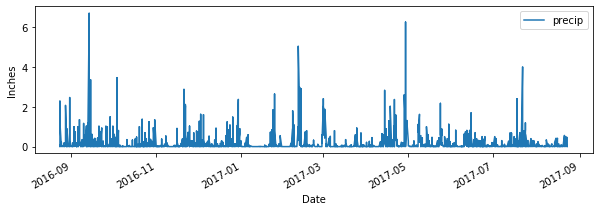

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
pplot = df.plot(figsize=(10,3),)
pplot.set_xlabel('Date')
pplot.set_ylabel('Inches')

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
stmt = session.query(Measurement).\
    order_by(Measurement.date.desc()).statement
df2 = pd.read_sql_query(stmt, session.bind)
df2.describe()

,id,prcp,tobs
count,19550.000000,18103.000000,19550.000000
mean,9775.500000,0.160644,73.097954
std,5643.743217,0.468746,4.523527
min,1.000000,0.000000,53.000000
25%,4888.250000,0.000000,70.000000
50%,9775.500000,0.010000,73.000000
75%,14662.750000,0.110000,76.000000
max,19550.000000,11.530000,87.000000


In [20]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.station).count()

9

In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
group_station = session.query(Measurement.station,func.count(Measurement.station)).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.tobs).desc()).all()
group_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [Measurement.station, 
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]
temp_averages = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).first()
temp_averages

('USC00519281', 54.0, 85.0, 71.66378066378067)

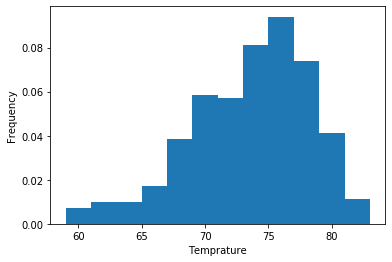

In [23]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date > query_date).all()
highest_tobs  = [result[0] for result in results[:]]
plt.hist(highest_tobs,density=True, bins=12)  # `density=False` would make counts
plt.ylabel('Frequency')
plt.xlabel('Temprature');

## Bonus Challenge Assignment

Temperature ananlysis 1

In [24]:
mon_str = '06'
june_temps = session.query(Measurement.date,func.avg(Measurement.tobs)).\
                           filter(func.strftime('%m', Measurement.date) == mon_str).\
                            group_by(func.strftime('%Y',Measurement.date)).all()
res_june = [ i[1] for i in june_temps ] 
del res_june[-1]
mon_str = '12'
dec_temps = session.query(Measurement.date, func.avg(Measurement.tobs)).\
                           filter(func.strftime('%m', Measurement.date) == mon_str).\
                            group_by(func.strftime('%Y',Measurement.date)).all()
res_dec = [ i[1] for i in dec_temps ] 

pop_mean = session.query(func.avg(Measurement.tobs)).scalar()


In [25]:
#Will use a paired t test to see of there is a statistical difference between june and dec tempratures
stats.ttest_rel(res_june,res_dec)

Ttest_relResult(statistic=7.780060705002921, pvalue=0.00023742611093245777)

In [26]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [27]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps('2012-02-28','2013-12-08')
trip_temps = [x for x in trip_temps[0]]
#trip_temps = [x for x in trip_temps]
trip_temps

[53.0, 72.82262540021345, 86.0]

In [45]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
peak_to_peak = trip_temps[2] - trip_temps[0]

y_axis = [trip_temps[1]]
x_axis = range(1,len(y_axis)+1)

<BarContainer object of 1 artists>

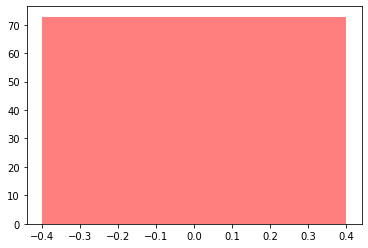

In [46]:
plt.bar([0],y_axis, color='r', alpha=0.5, align="center")

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [161]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
